In [13]:
import numpy as np
import torch
from torchvision import transforms, models, datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [14]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [15]:
# root = "./images/icemodelimages"
# transformation = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor()
#                                     ])
# data = datasets.ImageFolder(root = root, transform=transformation)

# csvloader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle = True)
# snow, nosnow = [], []
# for img, lbl in csvloader:
#     if(lbl == 1):
#         snow.append(img)
#     else:
#         nosnow.append(img)
# snow = torch.cat(snow, dim = 0)

# train_snow, test_snow = torch.split(snow, [int(0.8*len(snow)), len(snow) - int(0.8*len(snow))])
# nosnow = torch.cat(nosnow, dim = 0)

# train_nosnow, test_nosnow = torch.split(nosnow, [int(0.8*len(nosnow)), len(nosnow) - int(0.8*len(nosnow))])
# torch.save(train_snow, 'train_ice.pt')
# torch.save(test_snow, 'test_ice.pt')
# torch.save(train_nosnow, 'train_noice.pt')
# torch.save(test_nosnow, 'test_noice.pt')




In [16]:
transformation = transforms.Compose([transforms.RandomPerspective(0.6, p=0.5),transforms.GaussianBlur(5)])

class riverdataset(torch.utils.data.Dataset):
    def __init__(self, snow_file, nosnow_file, transform = None):
        """
        Arguments:
            snow_file (string): Path to the .pt file
            nosnow_file (string): Path to the .pt file
            noise (boolean): add guassian noise
        """
        snow = torch.load(snow_file)
        nosnow = torch.load(nosnow_file)
        labels1 = torch.tensor([1 for i in range(len(snow))])
        labels0 = torch.tensor([0 for i in range(len(nosnow))])
        self.data = torch.cat([snow, nosnow], dim= 0)
        self.labels = torch.cat([labels1, labels0], dim = 0)
        
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        if(self.transform):
            image = self.transform(image)
        return image, self.labels[idx]
    

train_set = riverdataset("train_snow.pt", "train_nosnow.pt", transformation)
test_set = riverdataset('test_snow.pt', "test_nosnow.pt", False)


In [17]:
#Create additional layers for snow classification
model = models.resnet50(weights =models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False   

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,2),
    torch.nn.Softmax(dim= 1)
)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
#parameters

lr = 0.0001
batch_size = 256
epochs =40
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr)
train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 1, shuffle= False)

In [25]:
def calc_test_accuracy(model, dataloader,epoch, save_pic = False, criterion =torch.nn.CrossEntropyLoss()):
      model.eval()
      TP = 0
      FP = 0
      TN = 0
      FN = 0
      val_loss = 0
      with torch.no_grad():
            for num, (i, l) in enumerate(dataloader):
                  if(save_pic):     
                        plt.imsave(f"image{num}.png",i.squeeze(0).permute(1,2,0).numpy() )
                 
                  if(l == torch.tensor([0])):
                        l = torch.tensor([1, 0])
                  else:
                        l = torch.tensor([0, 1])
                  l = l.reshape([1,2])
                  i,l = i.to(device), l.to(device).float()
                  t_out = model(i)
                  
                  
                  val_loss+= criterion(t_out, l).item()
                  predicted = np.argmax(t_out.cpu().numpy(), axis = 1)
                  true_label = np.argmax(l.cpu().numpy(), axis =1)
                 
                  if(predicted == 1 and true_label == 1):
                        TP +=1
                  elif(predicted == 0 and true_label == 0):
                        TN +=1
                  if(predicted == 1 and true_label == 0):
                        FP +=1
                        plt.imsave(f"imageFP{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
                  elif(predicted == 0 and true_label == 1):
                        FN +=1
                        plt.imsave(f"imageFN{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
            try:
                  precision = TP/(TP + FP)
            except:
                  precision = 0
            try:
                  recall = TP/(TP + FN)
            except:
                  recall = 0
            stats = dict(
                  epoch = epoch,
                  accuracy = (TN+TP) /(TP+TN+FP+FN),
                  precision = precision,
                  recall = recall,
                  loss = val_loss/(TP+FP+TN+FN)
            
            )
            # print(f'True positives: {TP}')
            # print(f'True negatives: {TN}')
            # print(f'False positives: {FP}')
            
            # print(f'False negatives: {FN}')
            return stats


In [20]:

#training loop
running_loss = 0 
train_loss, test_loss = [],[]
# model = torch.load("model.pth")
model.train()
verbose = 10
steps = 0

for epoch in range(0, epochs):
    print(epoch)
    for images,labels in train_loader:
        steps +=1
        labels = torch.nn.functional.one_hot(labels)
        images,labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    val_loss = 0
    num_correct = 0
    model.eval()
    train_loss.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        stats = calc_test_accuracy(model, test_loader, epoch+1)
        
        test_loss.append(stats["loss"])
        stats["training_loss"] = train_loss
        torch.save(stats, f"stats-{epoch+1}.pt")
        print(stats)
    running_loss= 0
    model.train()
    torch.save(model, 'model.pth')
    
  


        
    

0
{'epoch': 1, 'accuracy': 0.5714285714285714, 'precision': 0.5714285714285714, 'recall': 1.0, 'loss': 0.6637782605589271, 'training_loss': [0.6754091531038284]}
1
{'epoch': 2, 'accuracy': 0.5714285714285714, 'precision': 0.5714285714285714, 'recall': 1.0, 'loss': 0.6333255879685324, 'training_loss': [0.6754091531038284, 0.6339863588412603]}
2
{'epoch': 3, 'accuracy': 0.7717086834733894, 'precision': 0.7152899824253075, 'recall': 0.9975490196078431, 'loss': 0.5892619716853988, 'training_loss': [0.6754091531038284, 0.6339863588412603, 0.5930590281883875]}
3
{'epoch': 4, 'accuracy': 0.907563025210084, 'precision': 0.8976744186046511, 'recall': 0.946078431372549, 'loss': 0.5480625093901524, 'training_loss': [0.6754091531038284, 0.6339863588412603, 0.5930590281883875, 0.5500440622369448]}
4
{'epoch': 5, 'accuracy': 0.9131652661064426, 'precision': 0.9390862944162437, 'recall': 0.9068627450980392, 'loss': 0.5180409488056889, 'training_loss': [0.6754091531038284, 0.6339863588412603, 0.593059

In [27]:
model = torch.load('model.pth')
stats = calc_test_accuracy(model, test_loader, epoch+1)
stats["training_loss"] = train_loss
torch.save(stats, f"stats-{epoch+1}.pt")
print(stats)



{'epoch': 40, 'accuracy': 0.9845938375350141, 'precision': 0.9974937343358395, 'recall': 0.9754901960784313, 'loss': 0.3421547351097192, 'training_loss': [0.6754091531038284, 0.6339863588412603, 0.5930590281883875, 0.5500440622369448, 0.5216891219218572, 0.5001660709579786, 0.4806223412354787, 0.45782817900180817, 0.44860202570756275, 0.43623514225085575, 0.43403160572052, 0.42411019404729206, 0.4176198070247968, 0.41135235875844955, 0.40963007758061093, 0.407848301033179, 0.40149466941754025, 0.4014533758163452, 0.39829664180676144, 0.38992159565289813, 0.3855946436524391, 0.3871662790576617, 0.3835023194551468, 0.3838103637099266, 0.38140743722518283, 0.37903812527656555, 0.37547458459933597, 0.375934178630511, 0.3704073677460353, 0.3709212839603424, 0.3722221652666728, 0.3739012802640597, 0.3673485095302264, 0.3698373610774676, 0.3654659191767375, 0.3714005599419276, 0.3673068881034851, 0.36315591881672543, 0.3679962183038394, 0.3687649841109912]}


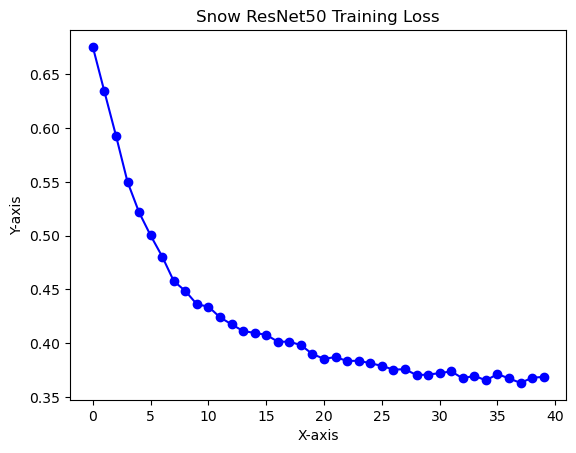

In [22]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(train_loss, marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow ResNet50 Training Loss')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

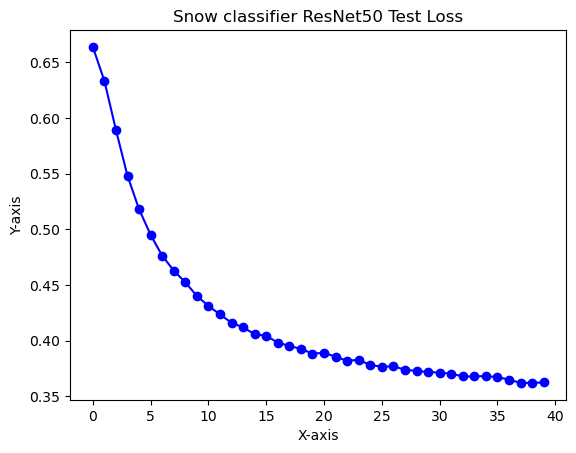

In [23]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(test_loss,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow classifier ResNet50 Test Loss')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

[0.5714285714285714, 0.5714285714285714, 0.7717086834733894, 0.907563025210084, 0.9131652661064426, 0.9131652661064426, 0.9159663865546218, 0.9131652661064426, 0.9131652661064426, 0.9243697478991597, 0.9229691876750701, 0.9369747899159664, 0.9397759103641457, 0.938375350140056, 0.9467787114845938, 0.9439775910364145, 0.9495798319327731, 0.9481792717086834, 0.957983193277311, 0.9509803921568627]


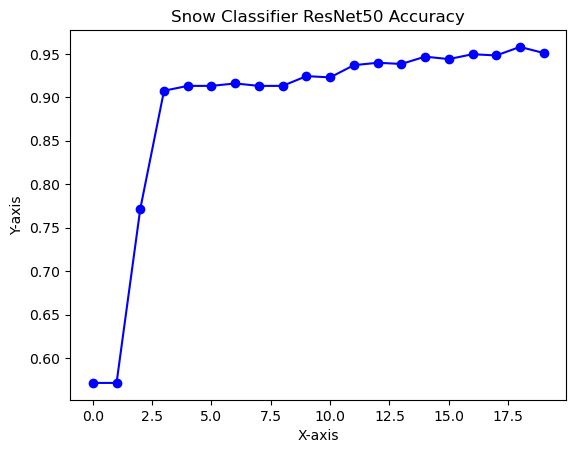

In [24]:
accuracies = []
fig, ax = plt.subplots()
for i in range(1,21):
    accuracies.append(torch.load(f'stats-{i}.pt')['accuracy'])
# Plot the data
print(accuracies)
ax.plot(accuracies,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow Classifier ResNet50 Accuracy')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

